<!-- # netcdf/numpy/xray/stats
import xarray as xr

# plotting packages
import seaborn as sns
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap



from metpy.units import units
import metpy
# import pint_xarray
import pytz

from sklearn.metrics import r2_score
import pandas as pd -->

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from sublimpy import tidy


import altair as alt
alt.data_transformers.enable('json') 

DataTransformerRegistry.enable('json')

# Inputs

In [2]:
start_date = '20221130'
end_date = '20230509'

In [3]:
try:
    tidy_df_30Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])

In [4]:
## Add q (mixing ratio) gradient variable
new_variable = (
    tidy_df_30Min.query("variable == 'mixingratio_3m_c'").value.values
    - tidy_df_30Min.query("variable == 'Tsurfmixingratio_rad_c'").value.values
) / 3

tidy_df_30Min = tidy.tidy_df_add_variable(
    tidy_df_30Min,
    new_variable,
    "q_gradient_3m_c",
    "mixing ratio gradient",
    3,
    'c'
)
## Add Net Rad variable
net_radiation_values = (
    (
        tidy_df_30Min.query("variable == 'Rsw_in_9m_d'")['value'].values
        +
        tidy_df_30Min.query("variable == 'Rlw_in_9m_d'")['value'].values
    ) - (
        tidy_df_30Min.query("variable == 'Rsw_out_9m_d'")['value'].values
        +
        tidy_df_30Min.query("variable == 'Rlw_out_9m_d'")['value'].values
    )
)



tidy_df_30Min = tidy.tidy_df_add_variable(
    tidy_df_30Min,
    net_radiation_values,
    'Rnet_9m_d',
    'net radiation',
    9,
    'd'
)


# Define case study dataframes

In [5]:
# Observation derived case studies
# NEW, LONG CASE STUDIES
case_study_intervals_ls = [
    pd.Interval(pd.Timestamp(2023,1,31), pd.Timestamp(2023,2,8)),  # synoptically weak, clear skies and calm
    # pd.Interval(pd.Timestamp(2023,2,15), pd.Timestamp(2023,2,23)), # synoptically active, blowing snow conditions
    # pd.Interval(pd.Timestamp(2023,3,16), pd.Timestamp(2023,3,24)), # snyoptically weak, clear skies and calm
    pd.Interval(pd.Timestamp(2023,3,25), pd.Timestamp(2023,4,2)), # snyoptically weak, clear skies and calm


    
    # pd.Interval(pd.Timestamp(2023,3,26), pd.Timestamp(2023,4,3)) # synoptically active, some blowing snow conditions
]
days_from_ls = [
    30, 
    # 45, 
    # 74, 
    83
    # 84
]

# OLD, SHORT CASE STUDIES
# case_study_intervals_ls = [
#     pd.Interval(pd.Timestamp(2023,1,31), pd.Timestamp(2023,2,4)),  # synoptically weak, clear skies and calm
#     pd.Interval(pd.Timestamp(2023,2,19), pd.Timestamp(2023,2,23)), # synoptically active, blowing snow conditions
#     pd.Interval(pd.Timestamp(2023,3,16), pd.Timestamp(2023,3,20)), # snyoptically weak, clear skies and calm
#     # pd.Interval(pd.Timestamp(2023,3,20), pd.Timestamp(2023,3,24)) # synoptically active, some blowing snow conditions
# ]
# days_from_ls = [30, 49, 74, 78]

# METHODOLOGICALLY-DERIVED CASE STUDIES
# case_study_intervals_ls = [
#     pd.Interval(pd.Timestamp(2022,12,21), pd.Timestamp(2022,12,24)),
#     pd.Interval(pd.Timestamp(2023,2,19), pd.Timestamp(2023,2,22)),
#     pd.Interval(pd.Timestamp(2023,3,5), pd.Timestamp(2023,3,8)),
#     pd.Interval(pd.Timestamp(2023,4,2), pd.Timestamp(2023,4,5))
# ]
# days_from_ls = [-11, 49, 63, 91]

case_study_df_ls = []

for interval, days_from in zip(case_study_intervals_ls, days_from_ls):
    df = tidy_df_30Min[tidy_df_30Min['time'] < interval.right]
    df = df[df['time'] >= interval.left]
    df['time'] = df['time'] - dt.timedelta(days=days_from)
    case_study_df_ls.append(df)

## Calculate cumulative sublimation for each case study (Separately)

In [6]:
for i in range(0, len(case_study_df_ls)):
    for variable in [
        'w_h2o__3m_uw',
        'w_h2o__3m_ue',
        'w_h2o__3m_c',
        'w_h2o__3m_d'
    ]:

        case_study_df_ls[i] = tidy.tidy_df_add_variable(
            case_study_df_ls[i],
            np.cumsum(case_study_df_ls[i].query(f"variable == '{variable}'")['value']*60*30).values*1000/(1e6),
            "Cumulative sublimation (mm)",
            "Cumulative sublimation (mm)",
            int(variable.split('_')[-2].split('m')[0]),
            variable.split('_')[-1]
        )

In [7]:
for i in range(0, len(case_study_df_ls)):
    case_study_df_ls[i] = case_study_df_ls[i].assign(case_study = str(case_study_intervals_ls[i]))

## Combine case study datasets into one dataframe (for plotting)

In [8]:
case_study_compare_src = pd.concat(case_study_df_ls)

# Plot time series

In [9]:
base_nolabels_with_facet_header = alt.Chart(case_study_compare_src).encode(
    alt.X('time:T').axis(labels=False).title(None),
    alt.Column('case_study:O').header(labelFontSize=18).title(None)
).properties(width=400, height=100)

base_nolabels = alt.Chart(case_study_compare_src).encode(
    alt.X('time:T').axis(labels=False).title(None),
    alt.Column('case_study:O').header(labels=False).title(None)
).properties(width=400, height=100)

base_nolabels_not_faceted = alt.Chart().encode(
    alt.X('time:T').axis(labels=False).title(None),
    # alt.Column('case_study:O').header(labels=False).title(None)
).properties(width=400, height=100)

base = alt.Chart(case_study_compare_src).encode(
    alt.X('time:T').axis(format="%H00").title('time (hour)'),
    alt.Column('case_study:O').header(labels=False).title(None)
).properties(width=400, height=100)

chart = (
    # CUMULATIVE SUBLIMATION PLOT
    base_nolabels_with_facet_header.transform_filter(
        alt.FieldOneOfPredicate('measurement', ['Cumulative sublimation (mm)'])
    ).transform_filter(
        alt.datum.height == 3
    ).transform_filter(
        alt.datum.tower == 'c'
    ).mark_line().encode(
        alt.Y("value:Q", title=['Cumulative', 'sublimation (mm)'], scale=alt.Scale(zero=False, nice=False))
    ) &
    # LATENT HEAT FLUX PLOT
    base_nolabels.transform_filter(
        alt.FieldOneOfPredicate('variable', ["w_h2o__3m_c", "w_h2o__5m_c", "w_h2o__10m_c", "w_h2o__20m_c"])
    ).transform_window(
        rolling_mean = 'mean(value)',
        frame= [-6, 6],
        groupby = ["height"]
    ).mark_line().encode(
        alt.Y("rolling_mean:Q", title = ['Latent heat flux', '(g/m^2/s)']).scale(domain=[-0.005, 0.015], clamp=True),
        alt.Color("height:N")
    ) & 
    # SENSIBLE HEAT FLUX PLOT
    base_nolabels.transform_filter(
        alt.FieldOneOfPredicate('variable', ["w_tc__3m_c", "w_tc__5m_c", "w_tc__10m_c", "w_tc__20m_c"])
    ).transform_window(
        rolling_mean = 'mean(value)',
        frame= [-6, 6],
        groupby = ["height"]
    ).mark_line().encode(
        alt.Y("rolling_mean:Q", title = ['Sensible heat flux', '(W/m^2)']),
        alt.Color("height:N")
    ) & 
    # Richardson number plot
    (
        base_nolabels_not_faceted.transform_filter(
            alt.FieldOneOfPredicate('variable', ['Ri_3m_c'])
        ).transform_window(
            rolling_avg = 'median(value)',
            frame=[-2,2],
            groupby = ["case_study"]
        ).mark_line().encode(
            alt.Y("rolling_avg:Q", title='Ri').scale(domain=[-2,2], clamp=True),
        )
        +
        alt.Chart(pd.DataFrame({'y': [0.25]})).mark_rule().encode(y='y')
        +
        alt.Chart(pd.DataFrame({'y': [-0.25]})).mark_rule().encode(y='y')
    ).facet(data = case_study_compare_src, column = alt.Column('case_study:O').header(labels=False).title(None)) &
    # Surface and Air Temp Plot
    base_nolabels.transform_filter(
        alt.FieldOneOfPredicate('variable', ['T_3m_c', 'Tsurf_rad_d'])
    ).mark_line().encode(
        alt.Y("value:Q", title="Temperature (˚C)"),
        alt.StrokeDash("measurement:N")
    ) & 
    # blowing snow flux
    base_nolabels.transform_filter(
        alt.datum.measurement == 'snow flux'
    ).mark_line().encode(
        alt.Y("value:Q", title=['Blowing Snow', 'Flux (g/m^2)']).scale(domain=[0,0.25], clamp=True),
        alt.Color("height:N")
    ) &
    # SW Incoming
    base.transform_filter(
        alt.datum.measurement == 'shortwave radiation incoming'
    ).mark_line().encode(
        alt.Y("value:Q", title=['SW Incoming', '(W/m^2)'])
    ) &
    # wind speed
    base.transform_filter(
        alt.datum.measurement == 'wind speed'
    ).transform_filter(
        alt.FieldOneOfPredicate('height', [2,3,10,20])
    ).mark_line().encode(
        alt.Y("value:Q", title=['Wind speed (m/s)']),
        alt.Color("height:N")
    ) &
    # RH
    base.transform_filter(
        alt.datum.measurement == 'RH'
    ).transform_filter(
        alt.FieldOneOfPredicate('height', [1,2,3,5,10,20])
    ).mark_line().encode(
        alt.Y("value:Q", title=['Relative Humidity (%)']),
        alt.Color("height:N")
    )
).resolve_scale(strokeDash='independent', color='independent').configure_axis(
    labelFontSize=14
)

In [10]:
chart.save('chart.svg')
chart

alt.VConcatChart(...)

In [11]:
alt.Chart(
    case_study_compare_src
).transform_filter(
    alt.FieldOneOfPredicate(
        "variable",
        ["tke_3m_c", "tke_5m_c", "tke_20m_c"]
    )
).transform_window(
    rolling_mean = 'mean(value)',
    frame= [-0, 0],
    groupby = ["variable"]
).mark_line().encode(
    alt.X('time:T').axis(format="%H00").title('time (hour)'),
    alt.Y("rolling_mean:Q", title = ['TKE', '(m^2/s^2)']),
    alt.Color("variable:N"),
    alt.Column('case_study:O').header(labels=False).title(None)
).properties(width=400, height=100).resolve_scale(color='independent', y='independent')

alt.Chart(...)

In [12]:

alt.Chart(
    case_study_compare_src
).transform_filter(
    alt.FieldOneOfPredicate(
        "variable",
        ["Rnet_9m_d"]
    )
).transform_window(
    rolling_mean = 'mean(value)',
    frame= [-0, 0],
    groupby = ["variable"]
).mark_line().encode(
    alt.X('time:T').axis(format="%H00").title('time (hour)'),
    alt.Y("rolling_mean:Q", title = ['Net Radiation', '(W/m^2)']),
    alt.Color("variable:N"),
    alt.Column('case_study:O').header(labels=False).title(None)
).properties(width=400, height=100)

alt.Chart(...)

In [13]:
alt.Chart(
    case_study_compare_src
).transform_filter(
    alt.FieldOneOfPredicate(
        "variable",
        ["w_h2o__3m_c", "u_h2o__3m_c", "v_h2o__3m_c"]
    )
).transform_window(
    rolling_mean = 'mean(value)',
    frame= [-6, 6],
    groupby = ["variable"]
).mark_line().encode(
    alt.X('time:T').axis(format="%H00").title('time (hour)'),
    alt.Y("rolling_mean:Q", title = ['Latent heat flux', '(g/m^2/s)']),
    alt.Color("variable:N"),
    alt.Column('case_study:O').header(labels=False).title(None)
).properties(width=400, height=100)

alt.Chart(...)

In [14]:
alt.Chart(
    case_study_compare_src
).transform_filter(
    alt.FieldOneOfPredicate(
        "variable",
        ["dir_3m_c", "dir_20m_c"]
    )
).transform_window(
    rolling_mean = 'mean(value)',
    frame= [-1, 1],
    groupby = ["variable"]
).mark_line().encode(
    alt.X('time:T').axis(format="%H00").title('time (hour)'),
    alt.Y("rolling_mean:Q").title("Wind Direction"),
    alt.Color("height:N").title("height (m)"),
    alt.Column('case_study:O').header(labels=False).title(None)
).properties(width=400, height=100).display(renderer='svg')

alt.Chart(...)

In [15]:
import seaborn as sns

def corrfunc(x, y, **kws):
    from scipy import stats
    import matplotlib
    import matplotlib.pyplot as plt
    # r, _ = stats.pearsonr(x, y)
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    # count how many annotations are already present
    n = len([c for c in ax.get_children() if 
                  isinstance(c, matplotlib.text.Annotation)])
    pos = (.1, .9 - .1*n)
    # or make positions for every label by hand
    # pos = (.1, .9) if kws['label'] == 'Yes' else (.1,.8)

    ax.annotate("{}: r = {:.2f}".format(kws['label'],r),
                xy=pos, xycoords=ax.transAxes)

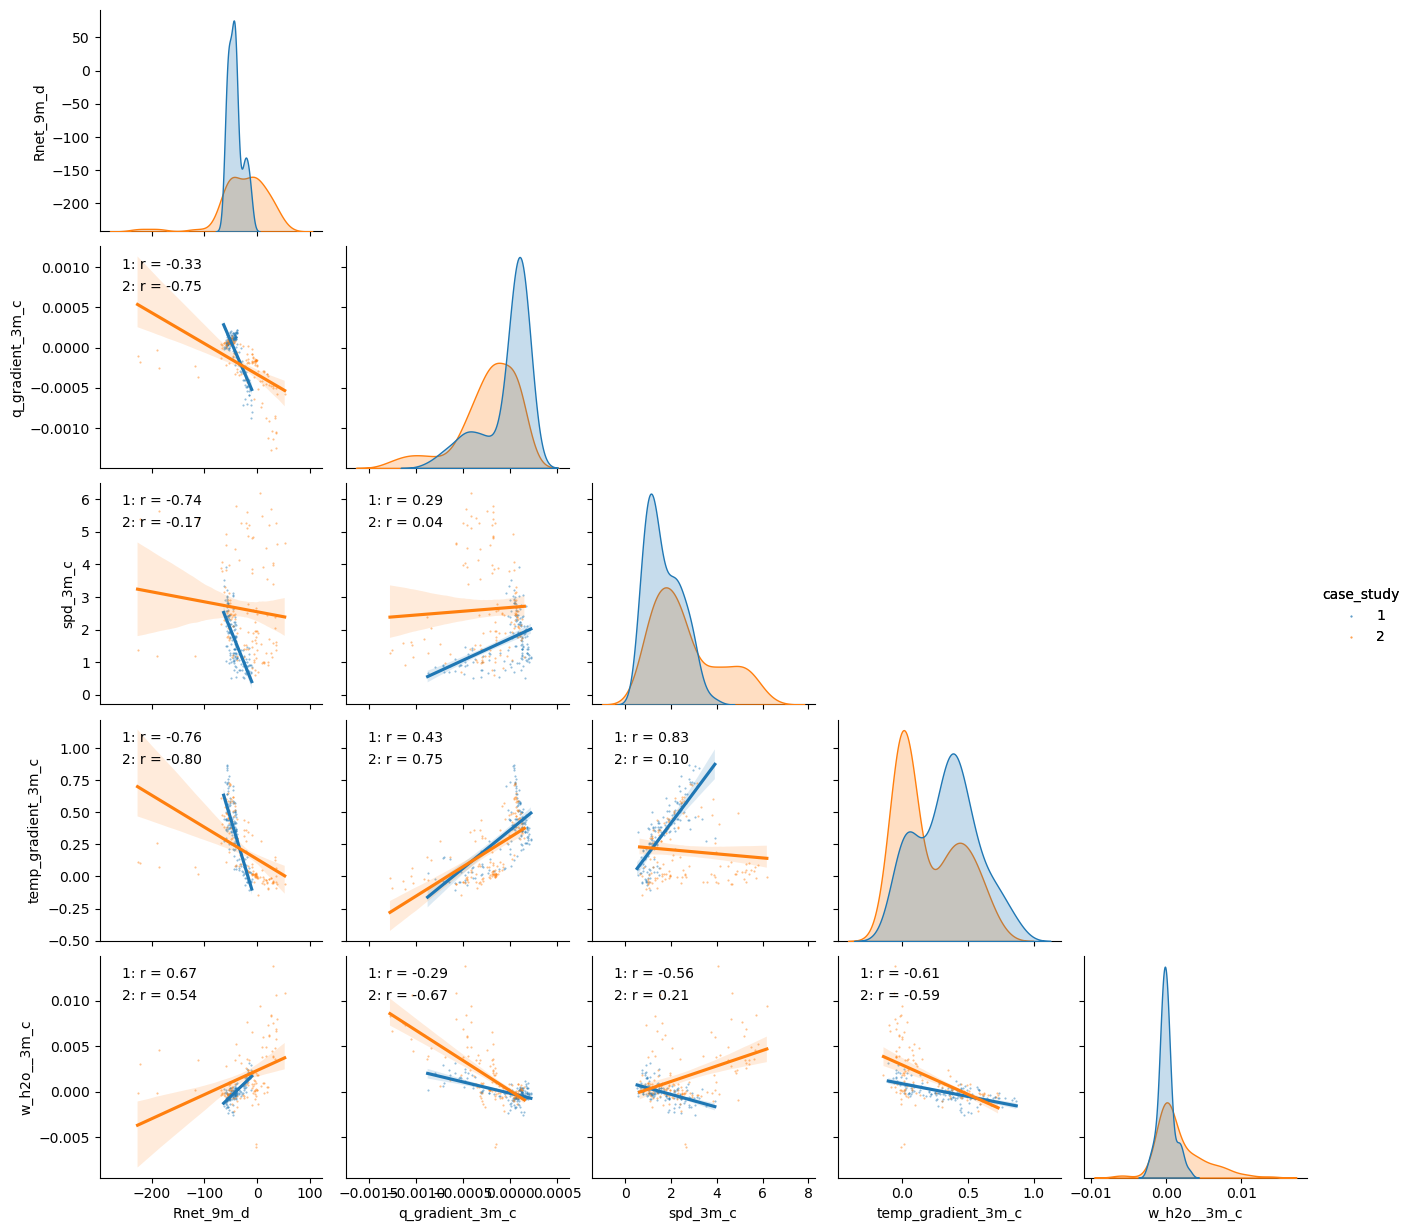

In [17]:
vars = ['q_gradient_3m_c', 'spd_3m_c', 'Rnet_9m_d', 'w_h2o__3m_c', 'temp_gradient_3m_c']
src = case_study_compare_src[case_study_compare_src.variable.isin(vars)].pivot_table(
    values = 'value',
    index = ['time', 'case_study'],
    columns='variable'
).reset_index()
src['day'] = src['time'].dt.day
src = src[src['day'].isin([2,3,4])]
src = src.drop(columns='day')
src['case_study'] = src['case_study'].apply({
    "(2023-01-31, 2023-02-08]": 1,
    # "(2023-03-16, 2023-03-24]": 2
    "(2023-03-25, 2023-04-02]": 2
}.get)
src = src.dropna()

g = sns.pairplot(
    data=src, 
    vars = ['Rnet_9m_d', 'q_gradient_3m_c', 'spd_3m_c', 'temp_gradient_3m_c', 'w_h2o__3m_c'], 
    hue='case_study',
    kind='reg',
    diag_kind='kde',
    palette=sns.color_palette("tab10")[:2],
    plot_kws={
            # 'line_kws': {'color': 'black'}, 
            'scatter_kws':{'s':0.25, 'alpha':0.5}
        }
)
g.map_lower(corrfunc)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g.add_legend()

# Plot Profiles

## With basic measurements

In [ ]:
profiles_src = case_study_compare_src.copy()

In [ ]:
lhflux_profiles_src = profiles_src[profiles_src['measurement'] == 'w_h2o_']
labels = ['0-4', '4-8', '8-12', '12-16', '16-20', '20-24']

lhflux_profiles_src['hour'] = lhflux_profiles_src['time'].dt.hour
lhflux_profiles_src['day'] = lhflux_profiles_src['time'].dt.day
lhflux_profiles_src['hour_group'] = pd.cut(
    lhflux_profiles_src['hour'], 
    [-1,4,8,12,16,20,24], 
    labels=labels
)

src = lhflux_profiles_src[
    lhflux_profiles_src.case_study == lhflux_profiles_src.case_study.unique()[1]
].query("tower == 'c'")

stderr_src = src.groupby(['hour_group', 'day', 'height']).sem()[['value']].rename(columns={"value": "stderr"})
mean_src = src.groupby(['hour_group', 'day', 'height']).mean()[['value']].rename(columns={"value": "mean"})
combo_src = stderr_src.merge(mean_src, left_index=True, right_index=True)
combo_src['lower err'] = combo_src['mean'] - combo_src['stderr']
combo_src['upper err'] = combo_src['mean'] + combo_src['stderr']
combo_src = combo_src.reset_index()
combo_src = combo_src[combo_src.hour_group.isin(['4-8', '8-12', '12-16', '16-20'])]

(
    alt.Chart(combo_src).mark_rule().encode(x=alt.datum(0)) +   
    alt.Chart(combo_src).mark_line().encode(
        alt.X("mean:Q", sort='-y'),
        alt.Y("height:Q")
    ).properties(width=150, height=75)
    +
    alt.Chart(combo_src).mark_area(opacity=0.25).encode(
        alt.X("lower err:Q", sort='-y').title("w'q' (g/m^2/s)"),
        alt.X2("upper err:Q"),
        alt.Y("height:Q")
    ).properties(width=150, height=75)
).facet(
        column = alt.Column("day:O"),
        row = alt.Row("hour_group:O", sort=labels)
    )

In [ ]:
profiles_src = profiles_src[profiles_src['time'].dt.minute == 0]
profiles_src = profiles_src[profiles_src['time'].dt.hour%4 == 0]
profiles_src['day'] = profiles_src['time'].dt.day
profiles_src['hour'] = profiles_src['time'].dt.hour

# profiles_src = profiles_src.query("hour <= 18")

t_profiles_src = profiles_src[profiles_src['variable'].isin([
    'Tsurf_c',
    'T_2m_c',
    'T_4m_c',
    'T_5m_c',
    'T_6m_c',
    'T_7m_c',
    'T_8m_c',
    'T_9m_c'
    'T_10m_c',
    'T_11m_c',
    'T_12m_c',
    'T_13m_c',
    'T_14m_c',
    'T_15m_c',
    'T_16m_c',
    'T_17m_c',
    'T_18m_c',
    'T_19m_c',
    'T_20m_c',
])]

spd_profiles_src = profiles_src[profiles_src['measurement'] == 'wind speed'].query("tower == 'c'")
q_profiles_src = profiles_src[profiles_src['measurement'] == 'mixing ratio'].query("tower == 'c'")
lhflux_profiles_src = profiles_src[profiles_src['measurement'] == 'w_h2o_'].query("tower == 'c'")
shflux_profiles_src = profiles_src[profiles_src['measurement'] == 'w_tc_'].query("tower == 'c'")
dir_profiles_src = profiles_src[profiles_src['measurement'] == 'wind direction'].query("tower == 'c'")

u_lhflux_profiles_src = profiles_src[profiles_src['measurement'] == 'u_h2o_'].query("tower == 'c'")
v_lhflux_profiles_src = profiles_src[profiles_src['measurement'] == 'v_h2o_'].query("tower == 'c'")

In [ ]:
def profiles_chart(t_profiles_src, spd_profiles_src, q_profiles_src, lhflux_profiles_src, shflux_profiles_src, dir_profiles_src, title):
    return (
        (alt.Chart(t_profiles_src).mark_line().encode(
            alt.X('value:Q').sort('-y').title("Temperature (˚C)").scale(domain=[-30, 5]),
            alt.Y("height:Q", title="Height (m)"),
            alt.Color("hour:N"),
        ).properties(height = 100, width = 150)).facet(column='day')
        &
        (alt.Chart().mark_line().encode(
            alt.X('value:Q').sort('-y').title('Wind speed (m/s)').scale(domain=[0,10]),
            alt.Y("height:Q", title="Height (m)"),
            alt.Color("hour:N"),
        ).properties(height = 100, width = 150) + alt.Chart().mark_rule().encode(alt.X("A"))).facet(alt.Column('day', header=None), data = spd_profiles_src.assign(A = 0))
        &
        (alt.Chart().mark_line().encode(
            alt.X('value:Q').sort('-y').title('Mixing ratio (g/g)').scale(domain=[0, 0.006]),
            alt.Y("height:Q", title="Height (m)"),
            alt.Color("hour:N"),
        ).properties(height = 100, width = 150) + alt.Chart().mark_rule().encode(alt.X("A"))).facet(alt.Column('day', header=None), data = q_profiles_src.assign(A = 0))
        &
        (alt.Chart().mark_line().encode(
            alt.X('value:Q').sort('-y').title('LH Flux (g/m^2/s)').scale(),
            alt.Y("height:Q", title="Height (m)"),
            alt.Color("hour:N"),
        ).properties(height = 100, width = 150) + alt.Chart().mark_rule().encode(alt.X("A"))).facet(alt.Column('day', header=None), data = lhflux_profiles_src.assign(A = 0))
        &
        (alt.Chart().mark_line().encode(
            alt.X('value:Q').sort('-y').title('SH Flux (˚C m/s)').scale(),
            alt.Y("height:Q", title="Height (m)"),
            alt.Color("hour:N"),
        ).properties(height = 100, width = 150) + alt.Chart().mark_rule().encode(alt.X("A"))).facet(alt.Column('day', header=None), data = shflux_profiles_src.assign(A = 0))
        &
        alt.Chart(dir_profiles_src).mark_line().encode(
                alt.X('value:Q').sort('-y').title("Wind direction (˚)"),
                alt.Y("height:Q", title="Height (m)"),
                alt.Color("hour:N"),
        ).properties(height = 100, width = 150).facet(column='day')
    ).properties(title=title)

def horizontal_chart(u_lhflux_profiles_src, v_lhflux_profiles_src, title):
    return ((
        alt.Chart().mark_line().encode(
            alt.X('value:Q').sort('-y').title("u'q' (g/m^2/s)").scale(domain=[-0.05,0.05], clamp=True),
            alt.Y("height:Q", title="Height (m)"),
            alt.Color("hour:N"),
        ).properties(height = 100, width = 150) + alt.Chart().mark_rule().encode(alt.X("A"))
    ).facet(
        alt.Column('day', header=None), data = u_lhflux_profiles_src.assign(A = 0)
    ) & (
        alt.Chart().mark_line().encode(
            alt.X('value:Q').sort('-y').title("v'q' (g/m^2/s)").scale(domain=[-0.05,0.05], clamp=True),
            alt.Y("height:Q", title="Height (m)"),
            alt.Color("hour:N"),
        ).properties(height = 100, width = 150) + alt.Chart().mark_rule().encode(alt.X("A"))
    ).facet(
        alt.Column('day', header=None), data = v_lhflux_profiles_src.assign(A = 0)
    )).properties(title=title)

In [ ]:
u_lhflux_profiles_src
v_lhflux_profiles_src
(
    horizontal_chart(
        u_lhflux_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"), 
        v_lhflux_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"),
        "Case Study 1"
    ) 
).configure_axis(grid=False).configure_title(anchor='middle')

In [ ]:
profiles_chart(
    t_profiles_src.query("day == 4").query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"), 
    spd_profiles_src.query("day == 4").query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"), 
    q_profiles_src.query("day == 4").query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"),
    lhflux_profiles_src.query("day == 4").query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"),
    shflux_profiles_src.query("day == 4").query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"),
    dir_profiles_src.query("day == 4").query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"),
    "Case Study 1"
)

In [ ]:
profiles_chart = (
    profiles_chart(
        t_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"), 
        spd_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"), 
        q_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"),
        lhflux_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"),
        shflux_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"),
        dir_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'"),
        "Case Study 1"
    ) | profiles_chart(
        t_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[1]}'"), 
        spd_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[1]}'"), 
        q_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[1]}'"),
        lhflux_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[1]}'"),
        shflux_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[1]}'"),
        dir_profiles_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[1]}'"),
        "Case Study 2"
    )
).configure_axis(grid=False).configure_title(anchor='middle')

In [ ]:
profiles_chart.save('profiles_chart.svg')
profiles_chart

## With near-snow-surface temperatures for case study 1

In [ ]:
profiles_src = case_study_compare_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[0]}'").copy()
profiles_src2 = case_study_compare_src.query(f"case_study == '{case_study_compare_src.case_study.unique()[1]}'").copy()

In [ ]:
alt.renderers.enable("default")

In [ ]:
(
    alt.Chart(
        profiles_src.query("measurement == 'snow temperature'")
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q"),
        alt.Color("height:O"),
        alt.Column("tower:O"),
        tooltip='height'
    ).properties(width = 600, height = 200) 
    &
    alt.Chart(
        profiles_src2.query("measurement == 'snow temperature'")
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q"),
        alt.Color("height:O"),
        alt.Column("tower:O"),
        tooltip='height'
    ).properties(width = 600, height = 200)
)

For case study 1: On tower d, use measurements from 1.1m and above. Snow is approximately 1m deep. Subtract 1m from all temperature measurements except surface
For case study 2: Snow has buried all the sensors

In [ ]:
# for second case study
profiles_src = profiles_src[profiles_src['time'].dt.minute == 0]
profiles_src = profiles_src[profiles_src['time'].dt.hour%4 == 0]
profiles_src['day'] = profiles_src['time'].dt.day
profiles_src['hour'] = profiles_src['time'].dt.hour

t_profiles_src = profiles_src[profiles_src['variable'].isin([
    'Tsurf_d',
    'Tsnow_1_1m_d',
    'Tsnow_1_2m_d',
    'Tsnow_1_3m_d',
    'Tsnow_1_4m_d',
    'T_2m_c',
    'T_4m_c',
    'T_5m_c',
    'T_6m_c',
    'T_7m_c',
    'T_8m_c',
    'T_9m_c'
    'T_10m_c',
    'T_11m_c',
    'T_12m_c',
    'T_13m_c',
    'T_14m_c',
    'T_15m_c',
    'T_16m_c',
    'T_17m_c',
    'T_18m_c',
    'T_19m_c',
    'T_20m_c',
])]

t_profiles_src['height'] = t_profiles_src['height'].apply(lambda x: 0.005 if x == 0 else x - 1)



# for second case study


profiles_src2 = profiles_src2[profiles_src2['time'].dt.minute == 0]
profiles_src2 = profiles_src2[profiles_src2['time'].dt.hour%4 == 0]
profiles_src2['day'] = profiles_src2['time'].dt.day
profiles_src2['hour'] = profiles_src2['time'].dt.hour

t_profiles_src2 = profiles_src2[profiles_src2['variable'].isin([
    'Tsurf_d',
    'Tsnow_1_1m_d',
    'Tsnow_1_2m_d',
    'Tsnow_1_3m_d',
    'Tsnow_1_4m_d',
    'T_2m_c',
    'T_4m_c',
    'T_5m_c',
    'T_6m_c',
    'T_7m_c',
    'T_8m_c',
    'T_9m_c'
    'T_10m_c',
    'T_11m_c',
    'T_12m_c',
    'T_13m_c',
    'T_14m_c',
    'T_15m_c',
    'T_16m_c',
    'T_17m_c',
    'T_18m_c',
    'T_19m_c',
    'T_20m_c',
])]

t_profiles_src2['height'] = t_profiles_src2['height'].apply(lambda x: 0.005 if x == 0 else x - 1)

### Case study 1: high res temp profiles

In [ ]:
(alt.Chart(t_profiles_src).transform_filter(
    alt.datum.height >= 1
).mark_line(point=True).encode(
    alt.X('value:Q').sort('-y').title(None).axis(labels=False),
    alt.Y("height:Q").title("height (m)").scale(domain=[1,20]).axis(values=[1,5,10,15,20]),
    alt.Color("hour:N")
).properties(height = 150, width = 200).facet(column = 'day') & \
alt.Chart(t_profiles_src).transform_filter(
    alt.datum.height < 1
).mark_line(point=True).encode(
    alt.X('value:Q').sort('-y').title("Temperature (˚C)"),
    alt.Y("height:Q").title("height (m)"),
    alt.Color("hour:N")
).properties(height = 75, width = 200).facet(alt.Column('day', header=alt.Header(title=None, labelFontSize=0)))).resolve_scale(x='shared').configure_concat(
    spacing=0
)

## With 2 days from each case study, look at all RH and mixing ratio profiles

In [ ]:
src = tidy_df_30Min.set_index("time").loc["2023-02-05": "2023-02-06"].reset_index().query("measurement == 'mixing ratio'").query("tower == 'c'")
src['quarter of day'] = pd.cut(src.time.dt.hour, [-1,5.5,11.5,17.5,24.5], labels=["0000-0530","0600-1130","1200-1730","1800-2330"])
src['hour'] = src.time.dt.hour
src['day'] = src.time.dt.day

alt.Chart(src).mark_line(size=2).encode(
    alt.X('value:Q').sort('-y').title("Temperature (˚C)"),
    alt.Y("height:Q"),
    alt.Column("quarter of day:O"),
    alt.Row("day:O"),
    alt.Color("time:O")
).properties(height = 150, width = 200).resolve_scale(color='independent')

In [ ]:
src = tidy_df_30Min.set_index("time").loc["2023-03-21": "2023-03-22"].reset_index().query("measurement == 'mixing ratio'").query("tower == 'c'")
src['quarter of day'] = pd.cut(src.time.dt.hour, [-1,5.5,11.5,17.5,24.5], labels=["0000-0530","0600-1130","1200-1730","1800-2330"])
src['hour'] = src.time.dt.hour
src['day'] = src.time.dt.day

chart = alt.Chart(src).mark_line(size=2).encode(
    alt.X('value:Q').sort('-y').title("Temperature (˚C)"),
    alt.Y("height:Q"),
    alt.Column("quarter of day:O"),
    alt.Row("day:O"),
    alt.Color("time:O")
).properties(height = 150, width = 200).resolve_scale(color='independent')

In [ ]:
chart